# Exercises MP

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from pulp import *
import pyomo.environ as pyomo
import nlopt

## Transport model

First in the matrix notation

In [2]:
D_mat = np.array([[3,7,6,23],[9,11,3,13],[17,6,13,7]])
print(D_mat)

[[ 3  7  6 23]
 [ 9 11  3 13]
 [17  6 13  7]]


In [3]:
Cost_mat = 5 + 5*D_mat
print(Cost_mat)

[[ 20  40  35 120]
 [ 50  60  20  70]
 [ 90  35  70  40]]


Flatten cost matrix to a column vector (n x 1)

In [4]:
c_vector = Cost_mat.reshape(-1,1)
print(c_vector)

[[ 20]
 [ 40]
 [ 35]
 [120]
 [ 50]
 [ 60]
 [ 20]
 [ 70]
 [ 90]
 [ 35]
 [ 70]
 [ 40]]


Add constraints

In [111]:
A_ub = np.array([
    [1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,1,1,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,1,1,1]
])
print(A_ub)
b_ub = np.array([100,75,90]).reshape(-1,1)
print(b_ub)

[[1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1]]
[[100]
 [ 75]
 [ 90]]


In [112]:
A_eq = np.concatenate([np.eye(4),np.eye(4),np.eye(4)],axis = 1)
print(A_eq)
b_eq = np.array([30,75,90,50]).reshape(-1,1)
print(b_eq)

[[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]]
[[30]
 [75]
 [90]
 [50]]


In [113]:
sol = optimize.linprog(c_vector, A_ub, b_ub, A_eq, b_eq)
print(sol)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 7425.0
              x: [ 3.000e+01  3.500e+01  1.500e+01  0.000e+00  0.000e+00
                   0.000e+00  7.500e+01  0.000e+00  0.000e+00  4.000e+01
                   0.000e+00  5.000e+01]
            nit: 6
          lower:  residual: [ 3.000e+01  3.500e+01  1.500e+01  0.000e+00
                              0.000e+00  0.000e+00  7.500e+01  0.000e+00
                              0.000e+00  4.000e+01  0.000e+00  5.000e+01]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  7.500e+01
                              4.500e+01  3.500e+01  0.000e+00  4.000e+01
                              7.500e+01  0.000e+00  4.000e+01  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf
                                    inf        inf        inf        inf
                                    inf        inf        inf 

In [114]:
minimal_cost = sol.fun
print('minimal_cost = ', minimal_cost)
duals_supply = sol.ineqlin
print('duals supply = ', duals_supply)
optimal_x = sol.x.reshape((3,4))
print('optimal_x = ', optimal_x)

minimal_cost =  7425.0
duals supply =    residual: [ 2.000e+01  0.000e+00  0.000e+00]
 marginals: [-0.000e+00 -1.500e+01 -5.000e+00]
optimal_x =  [[30. 35. 15.  0.]
 [ 0.  0. 75.  0.]
 [ 0. 40.  0. 50.]]


So interpretation dual supply: if 1 more unit would produced at the second location (Chicago), then the cost would drop by 15!

In [115]:
duals_demand = sol.eqlin
print('duals_demand', duals_demand)

duals_demand   residual: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 marginals: [ 2.000e+01  4.000e+01  3.500e+01  4.500e+01]


So if demand at site 1 (Miami) increases, then cost function rises with 20

Is correct! checked with GAMS!

## Blending problem

As both lower and upper constraint, scipy won't work anyymore => try pyomo. Inspired by https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/02.03-Linear-Blending-Problem.html and https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/02.05-Gasoline-Blending.html 

In [56]:
mass = 1 #mass of 1 kg
data = {    
    'Corn':{'cost':0.133,'nutrients':{  
        'Netenergy':1.48,
        'Protein':0.075,
        'Fat':0.0357,
        'Vitamin_a':600,
        'Salt':0,
        'Calcium':0.0002,
        'Phosphorus':0.0035
    }},
    'Dical':{'cost':0.498,'nutrients':{  
        'Netenergy':0,
        'Protein':0,
        'Fat':0,
        'Vitamin_a':0,
        'Salt':0,
        'Calcium':0.2313,
        'Phosphorus':0.1865
    }},
    'Alfalfa':{'cost':0.077,'nutrients':{  
        'Netenergy':0.49,
        'Protein':0.127,
        'Fat':0.022,
        'Vitamin_a':50880,
        'Salt':0,
        'Calcium':0.0125,
        'Phosphorus':0.0023
    }},
    'Salt':{'cost':0.11,'nutrients':{  
        'Netenergy':0,
        'Protein':0,
        'Fat':0,
        'Vitamin_a':0,
        'Salt':1,
        'Calcium':0,
        'Phosphorus':0
    }},
    'Soybeans':{'cost':0.3,'nutrients':{  
        'Netenergy':1.29,
        'Protein':0.438,
        'Fat':0.013,
        'Vitamin_a':80,
        'Salt':0,
        'Calcium':0.0036,
        'Phosphorus':0.0075
    }},
    'Vitamin_a':{'cost':0.286,'nutrients':{  
        'Netenergy':0,
        'Protein':0,
        'Fat':0,
        'Vitamin_a':2204600,
        'Salt':0,
        'Calcium':0,
        'Phosphorus':0
    }},
    'Urea':{'cost':0.332,'nutrients':{  
        'Netenergy':0,
        'Protein':2.62,
        'Fat':0,
        'Vitamin_a':0,
        'Salt':0,
        'Calcium':0,
        'Phosphorus':0.68
    }},
    'Potato_slurry':{'cost':0.250,'nutrients':{  
        'Netenergy':1.39,
        'Protein':0.032,
        'Fat':0.009,
        'Vitamin_a':0,
        'Salt':0,
        'Calcium':0.002,
        'Phosphorus':0.0024
    }}
}

In [82]:
constraints = { 
     'Netenergy':{'lower':1.34531,'upper':float('inf')},
    'Protein':{'lower':0.071,'upper':0.13},
    'Fat':{'lower':0,'upper':0.05},
    'Vitamin_a':{'lower':2200,'upper':float('inf')},
    'Salt':{'lower':0.015,'upper':0.02},
    'Calcium':{'lower':0.0025,'upper':0.01},
    'Phosphorus':{'lower':0.0035,'upper':0.012},
}

In [83]:
keys = constraints.keys()

In [84]:
list(keys)

['Netenergy', 'Protein', 'Fat', 'Vitamin_a', 'Salt', 'Calcium', 'Phosphorus']

In [85]:
data.keys()

dict_keys(['Corn', 'Dical', 'Alfalfa', 'Salt', 'Soybeans', 'Vitamin_a', 'Urea', 'Potato_slurry'])

In [86]:
data['Corn']['nutrients']['Salt']

0

In [87]:
# !pip install PyUtilib
# !pip install pyomo[clp]

In [88]:
def feed_blend(mass):
    nutrients = constraints.keys()
    ingredients = data.keys()
    model = pyomo.ConcreteModel()
    model.dual = pyomo.Suffix(direction=pyomo.Suffix.IMPORT)
    #define variables
    model.x = pyomo.Var(ingredients, domain = pyomo.NonNegativeReals)
    #define objective
    model.cost = pyomo.Objective(expr = sum(model.x[c]*data[c]['cost'] for c in ingredients))
    #define constraints
    model.mass = pyomo.Constraint(expr = mass == sum(model.x[c] for c in ingredients))
    #model.cons = pyomo.ConstraintList()
    model.cons = pyomo.Constraint(pyomo.Any)
    for nutrient in nutrients:
        #model.cons.add(sum(model.x[c]*data[c]['nutrients'][nutrient] for c in ingredients) >= constraints[nutrient]['lower'])
        #model.cons.add(sum(model.x[c]*data[c]['nutrients'][nutrient] for c in ingredients) <= constraints[nutrient]['upper'])
        model.cons[nutrient+'_lower'] = sum(model.x[c]*data[c]['nutrients'][nutrient] for c in ingredients) >= constraints[nutrient]['lower']
        model.cons[nutrient + '_upper'] = sum(model.x[c]*data[c]['nutrients'][nutrient] for c in ingredients) <= constraints[nutrient]['upper']
    #solve model
    solver = pyomo.SolverFactory('glpk')
    solver.solve(model).write()
    return model


In [89]:
model = feed_blend(mass)
model

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.128201868252725
  Upper bound: 0.128201868252725
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 9
  Number of nonzeros: 59
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.030997753143310547
# ----------------------------------------------------------
#   Solution Information
# ----------

In [90]:
results = pd.DataFrame()
ingredients = data.keys()
for ingredient in ingredients:
    results.loc[ingredient,'amount'] = model.x[ingredient]()
results

,amount
Corn,0.873480
Dical,0.004256
Alfalfa,0.107263
Salt,0.015000
Soybeans,0.000000
Vitamin_a,0.000000
Urea,0.000000
Potato_slurry,0.000000


Analogous direct output!

In [91]:
model.x.display()

x : Size=8, Index=x_index
    Key           : Lower : Value               : Upper : Fixed : Stale : Domain
          Alfalfa :     0 :   0.107263095662084 :  None : False : False : NonNegativeReals
             Corn :     0 :   0.873480461571337 :  None : False : False : NonNegativeReals
            Dical :     0 : 0.00425644276657883 :  None : False : False : NonNegativeReals
    Potato_slurry :     0 :                 0.0 :  None : False : False : NonNegativeReals
             Salt :     0 :  0.0150000000000004 :  None : False : False : NonNegativeReals
         Soybeans :     0 :                 0.0 :  None : False : False : NonNegativeReals
             Urea :     0 :                 0.0 :  None : False : False : NonNegativeReals
        Vitamin_a :     0 :                 0.0 :  None : False : False : NonNegativeReals


analogous to GAMS output!

<img src="GAMS_feed_output.png">

In [92]:
model.dual.display()

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key                    : Value
       cons[Calcium_lower] :   2.10950447562742
       cons[Calcium_upper] :                0.0
           cons[Fat_lower] :                0.0
           cons[Fat_upper] :                0.0
     cons[Netenergy_lower] : 0.0827746515658761
    cons[Phosphorus_lower] :                0.0
    cons[Phosphorus_upper] :                0.0
       cons[Protein_lower] :                0.0
       cons[Protein_upper] :                0.0
          cons[Salt_lower] : 0.0999283852126221
          cons[Salt_upper] :                0.0
     cons[Vitamin_a_lower] :                0.0
                      mass : 0.0100716147873779


How to variables are translated to the model

In [93]:
model.cons.display()

cons : Size=14
    Key              : Lower   : Body                 : Upper
       Calcium_lower :  0.0025 : 0.002500000000000001 :  None
       Calcium_upper :    None : 0.002500000000000001 :  0.01
           Fat_lower :     0.0 :  0.03354304058266258 :  None
           Fat_upper :    None :  0.03354304058266258 :  0.05
     Netenergy_lower : 1.34531 :   1.3453099999999998 :  None
     Netenergy_upper :    None :   1.3453099999999998 :  None
    Phosphorus_lower :  0.0035 : 0.004097713311489424 :  None
    Phosphorus_upper :    None : 0.004097713311489424 : 0.012
       Protein_lower :   0.071 :  0.07913344776693493 :  None
       Protein_upper :    None :  0.07913344776693493 :  0.13
          Salt_lower :   0.015 :   0.0150000000000004 :  None
          Salt_upper :    None :   0.0150000000000004 :  0.02
     Vitamin_a_lower :  2200.0 :    5981.634584229636 :  None
     Vitamin_a_upper :    None :    5981.634584229636 :  None


In [69]:
model.cost.display()

cost : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 0.1282018682527246


## Digester


In [23]:
#!pip install openpyxl

In [24]:
digester_data = pd.read_excel('data.xlsx', sheet_name = 'Parameters')
#digester_data['Debiet'] = digester_data['Tonnage']*digester_data['Dichtheid'] #What Jeroen does
digester_data['Debiet'] = digester_data['Tonnage']/digester_data['Dichtheid'] #Wat seems more logical too me
digester_data = digester_data.rename(columns = {'Unnamed: 0':'Oorsprong'})
digster_data = digester_data.set_index('Oorsprong', inplace = True)
digester_data

,Gate Fee,Tonnage,Dichtheid,Biogaspotentieel,Degradatie,Debiet
Oorsprong,,,,,,
KeukenafvalUgent,112.00,150.00,0.75,100.0,0.07,200.000000
DrijfmestUgent,6.50,1000.00,1.00,20.0,0.13,1000.000000
VasteMestUgent,1.68,1890.00,0.90,100.0,0.13,2100.000000
SpijsolieUgent,-400.00,13.76,0.90,850.0,0.12,15.288889
GroenafvalUgent,60.00,63.80,0.25,100.0,0.04,255.200000
PaardenmestUgent,1.68,3430.00,0.70,42.5,0.13,4900.000000
GroenafvalUZ,66.40,23.30,0.25,100.0,0.04,93.200000
KeukenafvalSodexoNP,72.50,120.00,0.75,100.0,0.07,160.000000
KeukenafvalSodexoP,72.50,240.00,0.75,100.0,0.07,320.000000


In [25]:
Q_tot = digester_data['Debiet'].sum()
print(Q_tot) #in m^3/year
Ton_tot = digester_data['Tonnage'].sum()

9617.733333333334


In [26]:
years = range(10)
r = 0.05 #deprecation rate

In [27]:
model_ad = pyomo.ConcreteModel()
model_ad.dual = pyomo.Suffix(direction=pyomo.Suffix.IMPORT)

specify the variables

In [28]:
model_ad.Volume = pyomo.Var([1], domain = pyomo.NonNegativeReals)
model_ad.theta_H = pyomo.Var([1], domain = pyomo.NonNegativeReals) #in days

specify the objective (here tried as one long function)

In [29]:
type(float(digester_data.loc[digester_data.index[0],'Gate Fee']))

float

In [30]:
origins = digester_data.index
from pyomo.environ import exp
model_ad.revenue = pyomo.Objective(
    expr = sum(
        (#the income
            sum(digester_data.loc[origin,'Gate Fee']*digester_data.loc[origin,'Gate Fee'] for origin in origins) +
             0.60*sum(digester_data.loc[origin,'Biogaspotentieel']*digester_data.loc[origin,'Tonnage']*
                      #(1-exp(float(-digester_data.loc[origin,'Degradatie'])*model_ad.Volume[1]/(Q_tot*365))) for origin in origins) - 
                      (1-exp(float(-digester_data.loc[origin,'Degradatie'])*model_ad.theta_H[1])) for origin in origins) - 
            #the operational cost
            (115846.03 + 110.37*Ton_tot - 691794)
        )/(1+r)**t for t in years
    ) - (558500 + 184.42*model_ad.Volume[1] + 64975),
    sense = pyomo.maximize
)

Add constraint

In [31]:
model_ad.cons_thetaH = pyomo.Constraint(expr = model_ad.theta_H[1]*Q_tot/365 == model_ad.Volume[1])

Solve model

In [32]:
nlp_solver = pyomo.SolverFactory('ipopt')
nlp_solver.solve(model_ad).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 2
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.12342023849487305
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [33]:
model_ad.Volume.display()

Volume : Size=1, Index=Volume_index
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      1 :     0 : 973.1701178712291 :  None : False : False : NonNegativeReals


If jeroen his interpretation is used, then the approximately the solution is obtained: $V \approx 670 m^3$

In [34]:
model_ad.dual.display()

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key         : Value
    cons_thetaH : 184.41999999322533


## Rainwatertank

In [35]:
rain_data = pd.read_excel('weatherdata.xlsx', index_col = 'obs')
rain_data = rain_data[['DATE','PRCP']] #only columns we need
rain_data.head()

,DATE,PRCP
obs,,
1,2000-01-01,0.04
2,2000-01-02,0.03
3,2000-01-03,0.00
4,2000-01-04,0.43
5,2000-01-05,0.00


<AxesSubplot: xlabel='obs'>

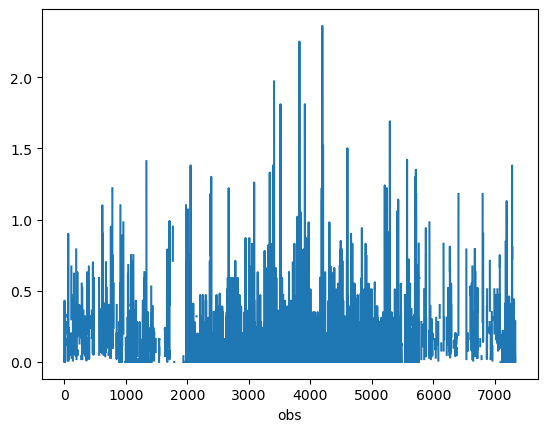

In [36]:
rain_data['PRCP'].plot()

Replace the Nans by zeroes

<AxesSubplot: xlabel='obs'>

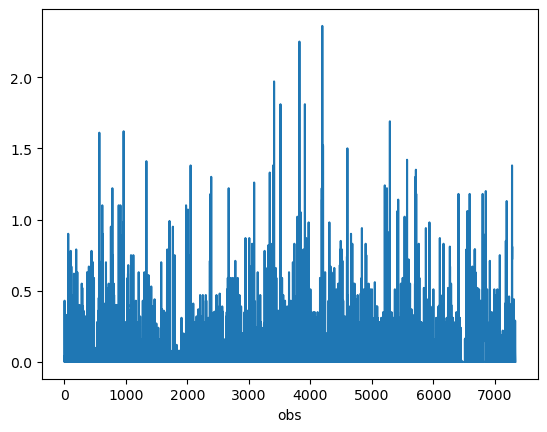

In [37]:
rain_data['PRCP'] = rain_data['PRCP'].fillna(0)
rain_data['PRCP'].plot()

Model instance

In [38]:
model_tank = pyomo.ConcreteModel()
model_tank.dual = pyomo.Suffix(direction=pyomo.Suffix.IMPORT)

3 variables are needed

In [39]:
model_tank.V_tank =  pyomo.Var([1], domain = pyomo.NonNegativeReals)
timesteps = rain_data.index.tolist()
model_tank.V_i = pyomo.Var(timesteps, domain = pyomo.NonNegativeReals)
model_tank.Vused_i = pyomo.Var(timesteps, domain = pyomo.NonNegativeReals)

Define an objective function and the constants/parameters associated

In [40]:
p_water = 0.0043 #euro/liter
a_roof = 200 #m^2
#assume that the rainfaill from the df in mm
#CONSEQUENCE is that mm*m^2 = liter

In [41]:
# model.cost = pyomo.Objective(
#     expr = sum(p_water*model_tank.Vused_i[i]/(1+0.02)**(365/i) for i in timesteps
#     ) - model_tank.V_tank[1]*0.0923*1.2
# )
model_tank.obj = pyomo.Objective(
    expr = sum(p_water*model_tank.Vused_i[i]/(1+0.02)**(i/365) for i in timesteps
    ) - model_tank.V_tank[1]*0.0923*1.2, sense=pyomo.maximize
)

Define constraints

In [42]:
model_tank.cons_consumption = pyomo.ConstraintList()
for i in timesteps:
    model_tank.cons_consumption.add(model_tank.Vused_i[i] <= model_tank.V_i[i])
V_consumption = 200 #l/d
model_tank.cons_consumption2 = pyomo.ConstraintList()
for i in timesteps:
    model_tank.cons_consumption2.add(model_tank.Vused_i[i] <= V_consumption)
model_tank.cons_volume_i = pyomo.ConstraintList()
for i in timesteps:
    model_tank.cons_volume_i.add(model_tank.V_i[i] <= model_tank.V_tank[1])
#start with an empty tank!
model_tank.t0 = pyomo.Constraint(expr = 0 == model_tank.V_i[1])
model_tank.cons_physical = pyomo.ConstraintList()
for i in timesteps[2:]:
    model_tank.cons_physical.add(model_tank.V_i[i] <= model_tank.V_i[i-1] + rain_data.loc[i,'PRCP']*a_roof - model_tank.Vused_i[i-1])

Solve the model

In [43]:
# #!conda install -c conda-forge nlopt
# try:
#     import ipopt
# except:
#     !pip install pyomo
#     !pip install pyomo[ipopt]

Note: eventually i installed ipopt manually and set its exe to my global PATH! https://www.coin-or.org/download/binary/Ipopt/ Here you can download it

In [44]:
nlp_solver = pyomo.SolverFactory('ipopt')
nlp_solver.solve(model_tank).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 29327
  Number of variables: 14665
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 10.73761773109436
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [45]:
model_tank.V_tank.display()

V_tank : Size=1, Index=V_tank_index
    Key : Lower : Value            : Upper : Fixed : Stale : Domain
      1 :     0 : 235.999987861921 :  None : False : False : NonNegativeReals


In [46]:
model_tank.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 343.7756762564167


## PERT

<img src="PERT_schema.png">

Create a matrix with the orders! so a matrix that represents this network.
Activities = A,B,C,D,E,F,G,H,J,K,L,M. We add an activity Z to represent to get a finish time

In [47]:
A_mat = np.zeros((13,13))
A_mat[0,1] = 1 #A -> B
A_mat[0,3] = 1 #A -> D
A_mat[1,2] = 1 #B -> C
A_mat[1,5] = 1 #B -> F
A_mat[2,12] = 1 #C -> Z 
A_mat[3,4] = 1 #D -> E
A_mat[3,7] = 1 #D -> H
A_mat[3,10] = 1 #D -> L
A_mat[4,2] = 1 #E -> C
A_mat[4,5] = 1 #E -> F
A_mat[5,8] = 1 #F -> J
A_mat[6,4] = 1 #G -> E
A_mat[6,7] =1 #G -> H
A_mat[6,10] = 1 #G -> L
A_mat[7,8] = 1 #H -> J
A_mat[8,12] = 1 #J -> Z
A_mat[9,11] = 1 #K -> M
A_mat[10,11] = 1 #L -> M
print(A_mat)

[[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Now define time per activity

In [48]:
deltat_act = np.array([7,11,31,17,0,26,23,15,7,33,14,4,0]) #no time for activity Z

In [49]:
pert = pyomo.ConcreteModel()
pert.dual = pyomo.Suffix(direction=pyomo.Suffix.IMPORT)

Define the variables

In [50]:
Activities = ['A','B','C','D','E','F','G','H','J','K','L','M','Z']
pert.t_fin_end = pyomo.Var([1], domain = pyomo.NonNegativeReals)
pert.t_fin_i = pyomo.Var(Activities, domain = pyomo.NonNegativeReals)

Define the constraints. For the 3 starting options (A,G,K), their finishing time is already known (equals time for their execution) and so these are first set

In [51]:
pert.Aconst = pyomo.Constraint(expr = pert.t_fin_i['A'] == deltat_act[0])
pert.Gconst = pyomo.Constraint(expr = pert.t_fin_i['G'] == deltat_act[6])
pert.Kconst = pyomo.Constraint(expr = pert.t_fin_i['K'] == deltat_act[9])
pert.cons = pyomo.ConstraintList()
for i,iletter in enumerate(Activities):
    for iacc,iaccletter in enumerate(Activities):
        pert.cons.add(A_mat[i,iacc]*(pert.t_fin_i[iletter] + deltat_act[iacc]) <= pert.t_fin_i[iaccletter])
pert.endtime_constraint = pyomo.Constraint(expr = pert.t_fin_end[1] == pert.t_fin_i['Z'])


Define the objective

In [52]:
pert.obj = pyomo.Objective(expr = pert.t_fin_end[1], sense = pyomo.minimize)

Now solver with a LP model

In [53]:
#solve model
solver = pyomo.SolverFactory('glpk')
solver.solve(pert).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 57.0
  Upper bound: 57.0
  Number of objectives: 1
  Number of constraints: 174
  Number of variables: 15
  Number of nonzeros: 193
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03399944305419922
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------

In [54]:
pert.t_fin_i.display()

t_fin_i : Size=13, Index=t_fin_i_index
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      A :     0 :   7.0 :  None : False : False : NonNegativeReals
      B :     0 :  18.0 :  None : False : False : NonNegativeReals
      C :     0 :  55.0 :  None : False : False : NonNegativeReals
      D :     0 :  24.0 :  None : False : False : NonNegativeReals
      E :     0 :  24.0 :  None : False : False : NonNegativeReals
      F :     0 :  50.0 :  None : False : False : NonNegativeReals
      G :     0 :  23.0 :  None : False : False : NonNegativeReals
      H :     0 :  39.0 :  None : False : False : NonNegativeReals
      J :     0 :  57.0 :  None : False : False : NonNegativeReals
      K :     0 :  33.0 :  None : False : False : NonNegativeReals
      L :     0 :  38.0 :  None : False : False : NonNegativeReals
      M :     0 :  42.0 :  None : False : False : NonNegativeReals
      Z :     0 :  57.0 :  None : False : False : NonNegativeReals


57 is the correct solution (checked with GAMS code)

In [55]:
#pert.dual.display() not shown since a very long list! logical with all these constraints

## Codon optimisation

No information given besides solution => not solved

## Extra exercise: resource allocation

A matrix: Aij = amount of resource x per unit of acitvit (a product here j)

In [245]:
A_mat = np.array([[0.8,1.2],[0.5,0.7],[0.4,1.0],[1,0.8]])
print(A_mat)
b_ub = np.array([140,90,120,125])
print(b_ub)
c = np.array([82-15,105-25])
c_neg = c*-1
print(c)

[[0.8 1.2]
 [0.5 0.7]
 [0.4 1. ]
 [1.  0.8]]
[140  90 120 125]
[67 80]


Easy to solve in scipy!

In [246]:
sol = optimize.linprog(c = c_neg, A_ub =A, b_ub = b_ub)
print(sol)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -10260.714285714284
              x: [ 6.786e+01  7.143e+01]
            nit: 2
          lower:  residual: [ 6.786e+01  7.143e+01]
                 marginals: [ 0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf]
                 marginals: [ 0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  6.071e+00  2.143e+01  0.000e+00]
                 marginals: [-4.714e+01 -0.000e+00 -0.000e+00 -2.929e+01]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0


Scipy cannot handle the facht that this a maximisation => to pyomo instead! for scipy change to minimisation problem

In [247]:
model_resources = pyomo.ConcreteModel()
model_resources.dual = pyomo.Suffix(direction = pyomo.Suffix.IMPORT)

Define the variables

In [248]:
products = ['functional','fancy']
model_resources.products = pyomo.Var(products, domain = pyomo.NonNegativeReals)

Define the constraints

In [249]:
resources = ['small_lathe','large_lathe','chair_carver','labour'] 
model_resources.cons = pyomo.Constraint(pyomo.Any)
for i,resource in enumerate(resources):
    model_resources.cons[resource] = sum(A_mat[i,j]*model_resources.products[product] for j,product in enumerate(products)) <= b_ub[i]

In [250]:
#imaginary extra constraints: at least 75 function chairs
model_resources.func_cons = pyomo.Constraint(expr = model_resources.products['functional'] >= 0)

Define the objective function

In [251]:
model_resources.profit = pyomo.Objective(expr = sum(c[j]*model_resources.products[product] for j,product in enumerate(products)), sense = pyomo.maximize)

solve the model

In [252]:
solver = pyomo.SolverFactory('glpk')
solver.solve(model_resources).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 10260.7142857143
  Upper bound: 10260.7142857143
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 3
  Number of nonzeros: 10
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03621506690979004
# ----------------------------------------------------------
#   Solution Information
# --------------

In [253]:
model_resources.products.display()

products : Size=2, Index=products_index
    Key        : Lower : Value            : Upper : Fixed : Stale : Domain
         fancy :     0 : 71.4285714285714 :  None : False : False : NonNegativeReals
    functional :     0 : 67.8571428571428 :  None : False : False : NonNegativeReals


In [254]:
model_resources.profit.display()

profit : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 10260.714285714279


In [255]:
model_resources.dual.display()

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key                : Value
    cons[chair_carver] :              0.0
          cons[labour] : 29.2857142857143
     cons[large_lathe] :              0.0
     cons[small_lathe] : 47.1428571428572
             func_cons :              0.0


Interpretation upper bound: if i would increase the upper limit of labour by one, then the profit would increase by 29.285!

Interpretation lower bound: if i would increase the amount of required functional chairs by one, then the profit would drop by -33!